In [ ]:
#| default_exp conv

# Convolutions

These were _almost_ directly copied from the corresponding notebook.

In [ ]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

from fastcore.test import test_close
import torch.nn.functional as F

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
torch.manual_seed(1103);

In [ ]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Understanding the convolution equations

If we have tensor A and tensor B, we can tile B over with overlaps. For each such tiling we can calculate the dot product and store in the resulting matrix C. C will be of the size equal to how B was tiled over A.

In [ ]:
x_train = x_train.reshape(-1, 28, 28)
x_valid = x_valid.reshape(-1, 28, 28)

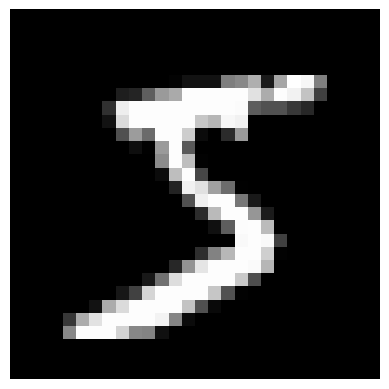

In [ ]:
img = x_train[0]
show_image(img);

In [ ]:
top_edge = torch.tensor([
    [-1, -1, -1,],
    [0, 0, 0,],
    [1, 1, 1]
], dtype=torch.float)

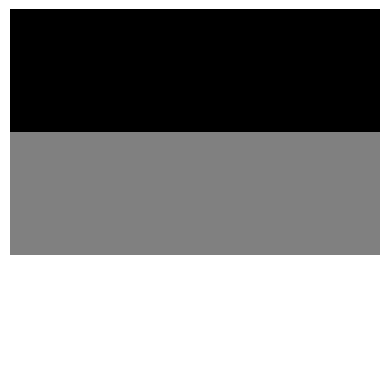

In [ ]:
show_image(top_edge);

In [ ]:
def apply_kernel(row, col, kernel):
    return (img[row-1:row+2, col-1:col+2] * kernel).sum()

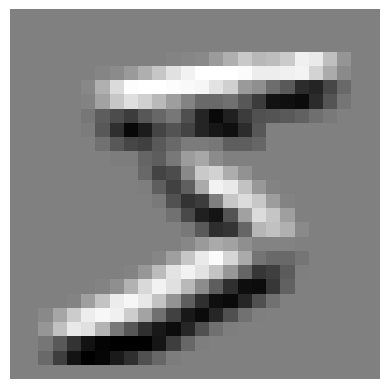

In [ ]:
result = [[apply_kernel(i, j, top_edge) for j in range(1, 27)] for i in range(1, 27)]
show_image(result);

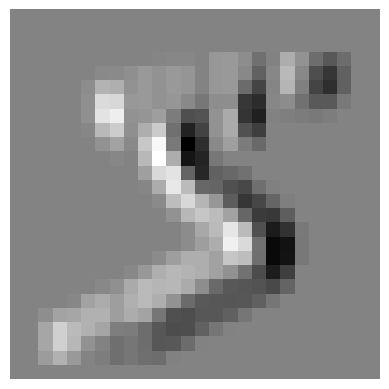

In [ ]:
left_edge = torch.tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], dtype=torch.float)
show_image([[apply_kernel(i, j, left_edge) for j in range(1, 27)] for i in range(1, 27)]);

## Convolutions in PyTorch

- $W$ - image width
- $H$ - image height
- $D$ - image depth
- $K$ - kernel size
- $N$ - number of filters

We got $W*H$ patches of size $K*K*D$. We need to calculate $M$ filters. If we layout all the patch x kernel calculations as 2 matrices, we'll get: $A=(W*H, K*K*D)$ and $B=(N, K*K*D)$. Now, $AB^\intercal = C = (W*H, N)$. And $C^\intercal$ is what we want. We can get this layout by 'extracting' each patch in the image and putting them into a matrix $A$ (rows are concatenations of patches with the same row and col but different depths) and by unrolling filters into columns of $B$. This works if we assume zero padding around the image.

In [ ]:
top_edge.view(-1)

tensor([-1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.])

In [ ]:
top_edge.numel

<function Tensor.numel>

In [ ]:
torch.tensor(result).shape

torch.Size([26, 26])

In [ ]:
a = torch.tensor(range(24)).reshape(2, 3, 4)
a

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

In [ ]:
k = 3
nw = 1
nh = 2
d = 2
acol = torch.ones(nh*nw, k*k*2) * -1
r = 0
for i in range(nw):
    for j in range(nh):
        c = 0
        for di in range(k):
            for dj in range(k):
                # print((i + di, j + dj), "->", (r, c))
                # acol[r, c] = a[0, i + di, j + dj] 

                acol[r, c::k*k] = a[:, i + di, j + dj] 
                c += 1
        r += 1
acol

tensor([[ 0.,  1.,  2.,  4.,  5.,  6.,  8.,  9., 10., 12., 13., 14., 16., 17.,
         18., 20., 21., 22.],
        [ 1.,  2.,  3.,  5.,  6.,  7.,  9., 10., 11., 13., 14., 15., 17., 18.,
         19., 21., 22., 23.]])

In [ ]:
def im2col_conv(img, kernels):
    d, w, h = img.shape
    n, d2, k, k = kernels.shape
    assert d == d2
    nw, nh = w - k + 1, h - k + 1

    A = torch.empty((nw*nh, k*k*d))
    r = 0
    for i in range(nw):
        for j in range(nh):
            c = 0
            for di in range(k):
                for dj in range(k):
                    A[r, c::k*k] = img[:, i + di, j + dj] 
                    c += 1
            r += 1
    
    B = torch.empty((k*k*d, n))
    for idx, kernel in enumerate(kernels):
        B[:, idx] = kernel.view(-1)
    return (A@B).T.reshape(n, nw, nh)


got = im2col_conv(img.unsqueeze(0), top_edge.unsqueeze(0).unsqueeze(0))
test_close(torch.tensor(result), got)

In [ ]:
k = 3
d = 1
n = 1

In [ ]:
kernels = top_edge.unsqueeze(0).unsqueeze(0)
B = torch.empty((k*k*d, n))
for idx, kernel in enumerate(kernels):
    B[:, idx] = kernel.view(-1)
test_close(B, kernels.reshape(n, -1).T)

In [ ]:
imgb = img.unsqueeze(0)
A = torch.empty((1, k*k*d))
r = 0
i = 12
j = 12
c = 0
# A[r, 0::k*k] = img[:, i, j], A[r, 1::k*k] = img[:, i, j + 1], ...
# A[r, k::k*k] = img[:, i + 1, j], ...
# ...
# A[r, k*(k-1):k*k] = img[:, i + (k - 1), j], ...
for di in range(k):
    for dj in range(k):
        A[r, c::k*k] = imgb[:, i + di, j + dj] 
        c += 1
r += 1
A

tensor([[0.7422, 0.9883, 0.2734, 0.1367, 0.9414, 0.8789, 0.0000, 0.3164, 0.9375]])

In [ ]:
imgb[:, i:i+k, j:j+k]

tensor([[[0.7422, 0.9883, 0.2734],
         [0.1367, 0.9414, 0.8789],
         [0.0000, 0.3164, 0.9375]]])

In [ ]:
test_close(A, imgb[:, i:i+k, j:j+k].flatten())

In [ ]:
def im2col_conv(img, kernels):
    d, w, h = img.shape
    n, d2, k, k = kernels.shape
    assert d == d2
    nw, nh = w - k + 1, h - k + 1

    A = torch.empty((nw*nh, k*k*d))
    r = 0
    for i in range(nw):
        for j in range(nh):
            A[r] = img[:, i:i+k, j:j+k].flatten()
            r += 1

    B = kernels.reshape(n, -1).T
    return (A@B).T.reshape(n, nw, nh)

got = im2col_conv(img.unsqueeze(0), top_edge.unsqueeze(0).unsqueeze(0))
test_close(torch.tensor(result), got)

In [ ]:
# k = 2, n = 4, h = 3, d = 1
# img
# 1     2/5        6/9         10
# 3/13  4/7/14/17  8/11/18/21  12/22
# 15    16/19      20/23       24
# A
# 1  2  3  4
# 5  6  7  8
# 9  10 11 12
# 13 14 15 16
# 17 18 19 20
# 21 22 23 24

In [ ]:
inp = torch.stack([x_train[0], x_train[1], x_train[2]])
kernels = torch.stack([torch.stack([top_edge]*3), torch.stack([left_edge]*3)])
got = im2col_conv(inp, kernels)
print(inp.shape, kernels.shape)
got.shape

torch.Size([3, 28, 28]) torch.Size([2, 3, 3, 3])


torch.Size([2, 26, 26])

In [ ]:
F.unfold?

Signature:
F.unfold(
    input: torch.Tensor,
    kernel_size: None,
    dilation: None = 1,
    padding: None = 0,
    stride: None = 1,
) -> torch.Tensor
Docstring:
Extracts sliding local blocks from a batched input tensor.

.. warning::
    Currently, only 4-D input tensors (batched image-like tensors) are
    supported.

.. warning::

    More than one element of the unfolded tensor may refer to a single
    memory location. As a result, in-place operations (especially ones that
    are vectorized) may result in incorrect behavior. If you need to write
    to the tensor, please clone it first.


See :class:`torch.nn.Unfold` for details
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/torch/nn/functional.py
Type:      function

In [ ]:
F.unfold(img[None, None], top_edge.shape).shape

torch.Size([1, 9, 676])

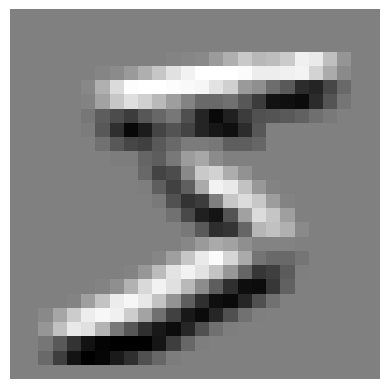

In [ ]:
show_image((top_edge.view(-1)@F.unfold(img[None, None], top_edge.shape)[0]).view(26, 26));

In [ ]:
%timeit -n 5 _=[[apply_kernel(i, j, top_edge) for j in range(1, 27)] for i in range(1, 27)]

8.99 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
%timeit -n 5 _=im2col_conv(img.unsqueeze(0), top_edge.unsqueeze(0).unsqueeze(0))

77.1 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
%timeit -n 100 _=(top_edge.view(-1)@F.unfold(img[None, None], top_edge.shape)[0]).view(26, 26)

36.4 µs ± 7.98 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit -n 100 _=F.conv2d(img[None, None], top_edge[None, None])

19.8 µs ± 8.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


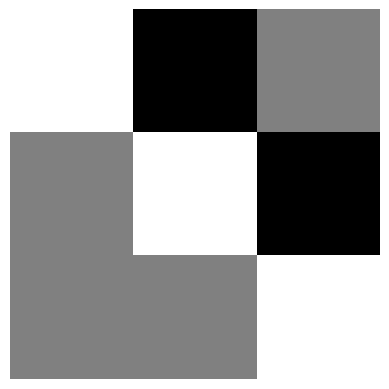

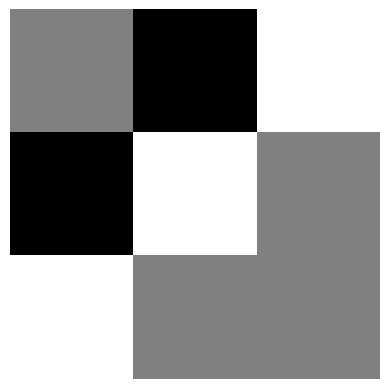

In [ ]:
diag_primary_right = torch.tensor([
    [1, -1, 0],
    [0, 1, -1],
    [0, 0, 1]
], dtype=torch.float)
diag_minor_left = torch.tensor([
    [0, -1, 1],
    [-1, 1, 0],
    [1, 0, 0]
], dtype=torch.float)
show_image(diag_primary_right);
show_image(diag_minor_left);

In [ ]:
xb = x_train[:8][:, None]
edges = torch.stack([top_edge, left_edge, diag_primary_right, diag_minor_left])[:, None]
xb.shape, edges.shape

(torch.Size([8, 1, 28, 28]), torch.Size([4, 1, 3, 3]))

In [ ]:
got = F.conv2d(xb, edges)
got.shape

torch.Size([8, 4, 26, 26])

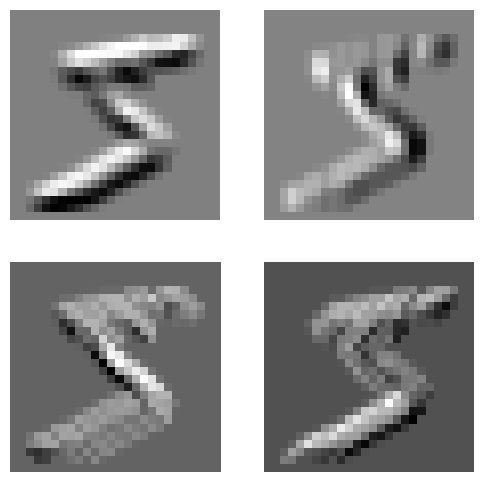

In [ ]:
show_images(got[0]);

## Strides and padding

When tiling over an image, we can jump over some elements instead of going over each possible position. The length of the jump is called stride.

If kernel size is larger than 1, then the resulting image is going to be smaller (assuming a stride of 1, by \<kernel size\> - 1). In order to control that, we can add padding (zero, reflect, nn, etc.) around the image. This will allow to apply the kernel near the edges.

# Creating the CNN

In [ ]:
x_train.shape, xb.shape

(torch.Size([50000, 28, 28]), torch.Size([8, 1, 28, 28]))

In [ ]:
n = x_train.shape[0]
c = y_train.max() + 1
n, c

(50000, tensor(10))

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 30, 3),
    nn.ReLU(),
    nn.Conv2d(30, 10, 3)
)
model(xb).shape

torch.Size([8, 10, 24, 24])

In [ ]:
#| export
def conv(ni, nf, ks=3, stride=2, act=True):
    result = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act:
        result = nn.Sequential(result, nn.ReLU())
    return result

In [ ]:
simple_cnn = nn.Sequential( # 28x28
    conv(1, 8),             # 14x14
    conv(8, 16),            #  7x7
    conv(16, 32),           #  4x4
    conv(32, 64),           #  2x2
    conv(64, 10, act=False),#  1x1
    nn.Flatten()
)

In [ ]:
simple_cnn(xb).shape

torch.Size([8, 10])

In [ ]:
x_train = x_train[:, None]
x_valid = x_valid[:, None]
x_train.shape, x_valid.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [ ]:
ds_train = Dataset(x_train, y_train)
ds_valid = Dataset(x_valid, y_valid)

In [ ]:
#|export
def_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#|export
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor):
        return x.to(device=device)
    if isinstance(x, Mapping):
        return {k: to_device(v, device) for k, v in x.items()}
    return type(x)(to_device(i, device) for i in x)

In [ ]:
#|export
def collate_device(b):
    return to_device(default_collate(b))

In [ ]:
bs = 64
lr = 0.5
dl_train, dl_valid = get_dls(ds_train, ds_valid, bs, collate_fn=collate_device)
opt = torch.optim.SGD(simple_cnn.parameters(), lr=lr)
simple_cnn = simple_cnn.to(def_device)

In [ ]:
loss, acc = fit(5, simple_cnn, opt, F.cross_entropy, dl_train, dl_valid)
loss, acc

Epoch 0: loss=0.1018, accuracy=0.97
Epoch 1: loss=0.0742, accuracy=0.98
Epoch 2: loss=0.0642, accuracy=0.98
Epoch 3: loss=0.2224, accuracy=0.94
Epoch 4: loss=0.0894, accuracy=0.98


(0.08937944243252277, 0.9759)

In [ ]:
opt = torch.optim.SGD(simple_cnn.parameters(), lr=lr/10)
loss, acc = fit(3, simple_cnn, opt, F.cross_entropy, dl_train, dl_valid)
loss, acc

Epoch 0: loss=0.0522, accuracy=0.99
Epoch 1: loss=0.0537, accuracy=0.99
Epoch 2: loss=0.0561, accuracy=0.99


(0.05605212048176909, 0.9874)

In the original linear model, we had:
- 768 * 50 + 50
- 50 * 10 + 10
- total: 38960
    
        linear(768, 50)
        linear(50, 10)

In CNN:
- 3 * 3 * 1 * 8 + 8
- 3 * 3 * 8 * 16 + 16
- 3 * 3 * 16 * 32 + 32
- 3 * 3 * 32 * 64 + 64
- 3 * 3 * 64 * 10 + 10
- total: 30154

        conv(1, 8),             # 14x14
        conv(8, 16),            #  7x7
        conv(16, 32),           #  4x4
        conv(32, 64),           #  2x2
        conv(64, 10, act=False) #  1x1

## Understanding convolution arithmetic

In PyTorch, a batch of images has 4 dimensions: Batch x Channels x Height x Width. Another representation is channels-last: BHWC. 

The receptive field is all the values in the original image that were used in the calculation of the output of a convolution.

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()